In [1]:
import pandas as pd
import os
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pycaret.anomaly import *

## 1. Lectura base de datos

In [3]:
data_path = r"D:\DANE - Contrato\2024\Operativo Barrido\Data"
emicron = pd.read_csv(os.path.join(data_path,"emicron_establecimientos.csv"),header = 0)
emicron = emicron[emicron['OLA']==2022].reset_index(drop=True)
emicron.drop('OLA',axis=1,inplace=True)

In [4]:
emicron.head()

id  VENTAS_MES_ANTERIOR  POTTOT  REMUNERACION_TOTAL      CYG  \
0  212002411              2000000     0.0                 0.0  1110000   
1  212003711              1950000     0.0                 0.0  1152000   
2  212003812              5600000     1.0            400000.0  4200000   
3  212007611              2940000     1.0                 0.0  2090000   
4  212008611             20000000     1.0            600000.0  9779000   

   COD_DEPTO  CPAM  GRUPOS4  UBICA  IDRUT  REG_CONT  CAMCOMER  
0          8     0        4      1      0         3         0  
1          8     0        4      3      0         4         0  
2          8     0        4      3      0         4         0  
3          8     0        3      3      0         4         0  
4          8     0        3      1      1         4         1

### Librería pycaret

In [5]:
emicron.set_index('id',inplace = True, drop = True)

emicron_data = setup(emicron,
                     categorical_features= ['COD_DEPTO','GRUPOS4', 'UBICA','REG_CONT'],
                   session_id = 123)

In [6]:
emicron_data.dataset_transformed.columns

Index(['VENTAS_MES_ANTERIOR', 'POTTOT', 'REMUNERACION_TOTAL', 'CYG',
       'COD_DEPTO_8.0', 'COD_DEPTO_13.0', 'COD_DEPTO_44.0', 'COD_DEPTO_47.0',
       'COD_DEPTO_70.0', 'COD_DEPTO_20.0', 'COD_DEPTO_25.0', 'COD_DEPTO_11.0',
       'COD_DEPTO_18.0', 'COD_DEPTO_41.0', 'COD_DEPTO_15.0', 'COD_DEPTO_68.0',
       'COD_DEPTO_54.0', 'COD_DEPTO_76.0', 'COD_DEPTO_52.0', 'COD_DEPTO_19.0',
       'COD_DEPTO_17.0', 'COD_DEPTO_63.0', 'COD_DEPTO_73.0', 'COD_DEPTO_66.0',
       'COD_DEPTO_5.0', 'COD_DEPTO_23.0', 'COD_DEPTO_27.0', 'COD_DEPTO_50.0',
       'COD_DEPTO_88.0', 'CPAM', 'GRUPOS4_4.0', 'GRUPOS4_3.0', 'GRUPOS4_2.0',
       'UBICA', 'IDRUT', 'REG_CONT_3.0', 'REG_CONT_4.0', 'REG_CONT_2.0',
       'REG_CONT_1.0', 'CAMCOMER'],
      dtype='object')

In [7]:
iforest = create_model('iforest',  max_features = 25, n_estimators = 1000)
print(iforest)

IForest(behaviour='new', bootstrap=False, contamination=0.05, max_features=25,
    max_samples='auto', n_estimators=1000, n_jobs=-1, random_state=123,
    verbose=0)


In [8]:
iforest_results = assign_model(iforest)
iforest_results.head()

VENTAS_MES_ANTERIOR  POTTOT  REMUNERACION_TOTAL      CYG  \
id                                                                    
212002411              2000000     0.0                 0.0  1110000   
212003711              1950000     0.0                 0.0  1152000   
212003812              5600000     1.0            400000.0  4200000   
212007611              2940000     1.0                 0.0  2090000   
212008611             20000000     1.0            600000.0  9779000   

           COD_DEPTO  CPAM  GRUPOS4  UBICA  IDRUT  REG_CONT  CAMCOMER  \
id                                                                      
212002411          8     0        4      1      0         3         0   
212003711          8     0        4      3      0         4         0   
212003812          8     0        4      3      0         4         0   
212007611          8     0        3      3      0         4         0   
212008611          8     0        3      1      1         4         1   

           Anomaly  Anomaly_Score  
id                                 
212002411        0      -0.052609  
212003711        0      -0.065853  
212003812        0      -0.039601  
212007611        0      -0.059298  
212008611        0      -0.014760

In [9]:
iforest_results['Anomaly'].value_counts()

0    21642
1     1140
Name: Anomaly, dtype: int64

<AxesSubplot:xlabel='CYG', ylabel='VENTAS_MES_ANTERIOR'>

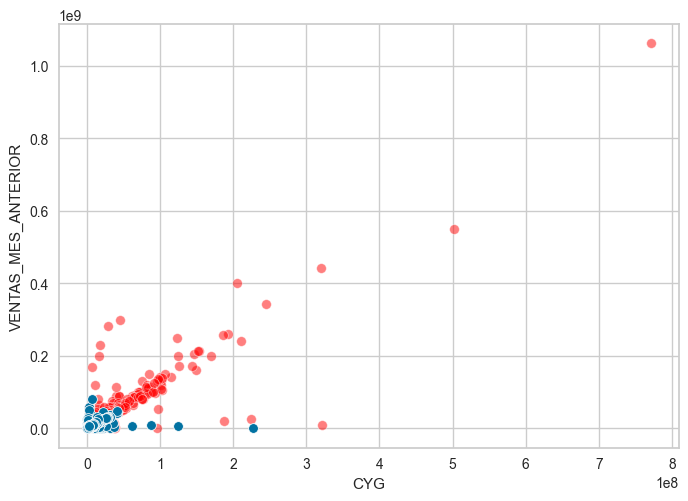

In [10]:
sns.scatterplot(x="CYG", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==1],color='red', alpha = 0.5)
sns.scatterplot(x="CYG", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==0])

<AxesSubplot:xlabel='REMUNERACION_TOTAL', ylabel='VENTAS_MES_ANTERIOR'>

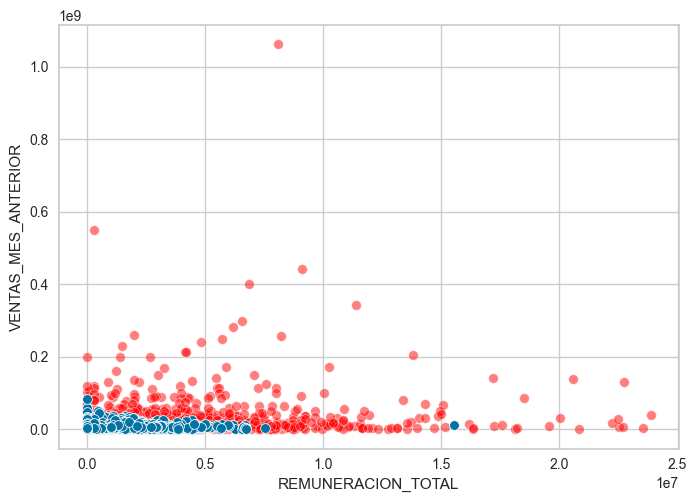

In [101]:
sns.scatterplot(x="REMUNERACION_TOTAL", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==1],color='red', alpha = 0.5)
sns.scatterplot(x="REMUNERACION_TOTAL", y='VENTAS_MES_ANTERIOR', data= iforest_results[iforest_results['Anomaly']==0])

### Librería scikit-learn

In [4]:
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import OneHotEncoder

#### One-hot encoding

In [5]:
emicron = pd.read_csv(os.path.join(data_path,"emicron_establecimientos.csv"),header = 0)
emicron = emicron[emicron['OLA']==2022].reset_index(drop=True)
emicron.drop('OLA',axis=1,inplace=True)

In [6]:
emicron_ohe = emicron.copy()

ohe_dpto = OneHotEncoder().fit(emicron_ohe[['COD_DEPTO']])
drop_enc = ohe_dpto.transform(emicron_ohe[['COD_DEPTO']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_dpto.get_feature_names_out())
#drop_enc_df.drop('COD_DEPTO_5', axis=1, inplace = True) # Utilizar como categoría de referencia 5: Antioquia

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_ubi = OneHotEncoder().fit(emicron_ohe[['UBICA']])
drop_enc = ohe_ubi.transform(emicron_ohe[['UBICA']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_ubi.get_feature_names_out())
drop_enc_df.drop('UBICA_3', axis=1, inplace = True)  # Utilizar como categoría de referencia 3: Vivienda (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_sector = OneHotEncoder().fit(emicron_ohe[['GRUPOS4']])
drop_enc = ohe_sector.transform(emicron_ohe[['GRUPOS4']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_sector.get_feature_names_out())
#drop_enc_df.drop('GRUPOS4_2', axis=1, inplace = True) # Utilizar como categoría de referencia 2: Industria Manufacturera

emicron_ohe = emicron_ohe.join(drop_enc_df)

ohe_conta = OneHotEncoder().fit(emicron_ohe[['REG_CONT']])
drop_enc = ohe_conta.transform(emicron_ohe[['REG_CONT']]).toarray()
drop_enc_df = pd.DataFrame(drop_enc,columns = ohe_conta.get_feature_names_out())
#drop_enc_df.drop('REG_CONT_4', axis=1, inplace = True) # Utilizar como categoría de referencia 4: No lleva registros (aplica sólo para Establecimientos)

emicron_ohe = emicron_ohe.join(drop_enc_df)

In [39]:
emicron_ohe.drop(['COD_DEPTO','UBICA','GRUPOS4','REG_CONT'],axis=1, inplace= True) 
emicron_ohe.set_index('id',inplace = True, drop = True)

In [23]:
Iforest = IsolationForest(max_samples='auto', 
                          random_state = 123,
                          contamination=0.05,
                          max_features= 25,
                          n_estimators=1000,
                          verbose=1,
                          n_jobs=-1)
Iforest.fit(emicron_ohe)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    2.3s remaining:    7.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    2.4s finished


IsolationForest(contamination=0.05, max_features=25, n_estimators=1000,
                n_jobs=-1, random_state=123, verbose=1)

In [41]:
y_pred = Iforest.predict(emicron_ohe)
y_pred_adjusted = [1 if x == -1 else 0 for x in y_pred]
sum(y_pred_adjusted)

1140

In [73]:
score = Iforest.score_samples(emicron_ohe)

In [50]:
score = Iforest.decision_function(emicron_ohe)

In [74]:
emicron['Anomaly'] = y_pred_adjusted
emicron['Anomaly_Score'] = score

In [48]:
emicron['id'][emicron['Anomaly']==1].isin(iforest_results[iforest_results['Anomaly']==1].index).sum()

1058

In [75]:
iforest_results[iforest_results['Anomaly']==1]

VENTAS_MES_ANTERIOR  POTTOT  REMUNERACION_TOTAL       CYG  \
id                                                                     
212014712             14500000     3.0           1893000.0   6860000   
212070011             15700000     2.0           1200000.0  13380000   
212081211             36000000     3.0           5235000.0  23058000   
212081212             19600000     2.0           3040000.0  12658000   
212087411              8500000     2.0                 0.0   5800000   
...                        ...     ...                 ...       ...   
727403212             60000000     0.0                 0.0  51600000   
727465612             57142857     4.0          10900000.0  43160000   
727558412              6000000     2.0           2540000.0   3544000   
727616411             11000000     4.0           6503000.0  12695941   
727686211             25000000     5.0          10854284.0  19880000   

           COD_DEPTO  CPAM  GRUPOS4  UBICA  IDRUT  REG_CONT  CAMCOMER  \
id                                                                      
212014712          8     0        3      1      1         2         1   
212070011         44     0        4      1      0         4         0   
212081211         47     0        3      1      1         1         1   
212081212         47     0        3      1      1         1         1   
212087411         47     0        4      1      1         1         1   
...              ...   ...      ...    ...    ...       ...       ...   
727403212         52     1        3      1      1         2         0   
727465612         68     1        2      1      1         1         1   
727558412         68     0        2      1      1         2         1   
727616411         25     0        3      1      1         1         1   
727686211         88     1        3      1      1         1         1   

           Anomaly  Anomaly_Score  
id                                 
212014712        1       0.004336  
212070011        1       0.001116  
212081211        1       0.049416  
212081212        1       0.013902  
212087411        1       0.004370  
...            ...            ...  
727403212        1       0.025374  
727465612        1       0.104544  
727558412        1       0.023851  
727616411        1       0.044509  
727686211        1       0.057765  

[1140 rows x 13 columns]

In [76]:
emicron[emicron['Anomaly']==1]

id  VENTAS_MES_ANTERIOR  POTTOT  REMUNERACION_TOTAL       CYG  \
14     212014712             14500000     3.0           1893000.0   6860000   
60     212070011             15700000     2.0           1200000.0  13380000   
72     212081211             36000000     3.0           5235000.0  23058000   
73     212081212             19600000     2.0           3040000.0  12658000   
77     212087411              8500000     2.0                 0.0   5800000   
...          ...                  ...     ...                 ...       ...   
22636  727403212             60000000     0.0                 0.0  51600000   
22670  727465612             57142857     4.0          10900000.0  43160000   
22710  727558412              6000000     2.0           2540000.0   3544000   
22737  727616411             11000000     4.0           6503000.0  12695941   
22773  727686211             25000000     5.0          10854284.0  19880000   

       COD_DEPTO  CPAM  GRUPOS4  UBICA  IDRUT  REG_CONT  CAMCOMER  Anomaly  \
14             8     0        3      1      1         2         1        1   
60            44     0        4      1      0         4         0        1   
72            47     0        3      1      1         1         1        1   
73            47     0        3      1      1         1         1        1   
77            47     0        4      1      1         1         1        1   
...          ...   ...      ...    ...    ...       ...       ...      ...   
22636         52     1        3      1      1         2         0        1   
22670         68     1        2      1      1         1         1        1   
22710         68     0        2      1      1         2         1        1   
22737         25     0        3      1      1         1         1        1   
22773         88     1        3      1      1         1         1        1   

       Anomaly_Score  
14         -0.468726  
60         -0.457477  
72         -0.511135  
73         -0.475025  
77         -0.466714  
...              ...  
22636      -0.480205  
22670      -0.562020  
22710      -0.476664  
22737      -0.491323  
22773      -0.512304  

[1140 rows x 14 columns]

In [77]:
np.percentile(np.sort(score), 5) 

-0.45687833245163295

In [78]:
len(score[score < np.percentile(np.sort(score), 5) ])

1140

(array([  14.,   23.,   66.,  145.,  275.,  592., 1516., 3709., 8577.,
        7865.]),
 array([-0.5834062 , -0.56243293, -0.54145966, -0.52048639, -0.49951312,
        -0.47853984, -0.45756657, -0.4365933 , -0.41562003, -0.39464676,
        -0.37367349]),
 <BarContainer object of 10 artists>)

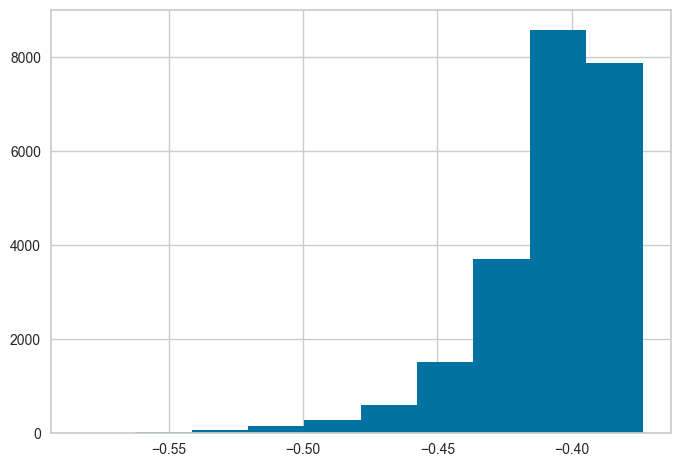

In [79]:
plt.hist(score)

In [67]:
emicron['Anomaly_Score'][emicron['Anomaly']==1].describe()

count    1.140000e+03
mean    -2.644671e-02
std      2.454487e-02
min     -1.265279e-01
25%     -3.824957e-02
50%     -1.886663e-02
75%     -7.370123e-03
max     -5.968463e-07
Name: Anomaly_Score, dtype: float64

In [68]:
emicron['Anomaly_Score'][emicron['Anomaly']==0].describe()

count    21642.000000
mean         0.052717
std          0.017862
min          0.000011
25%          0.041978
50%          0.056861
75%          0.066235
max          0.083205
Name: Anomaly_Score, dtype: float64

In [7]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        return(df)

In [8]:
from sklearn.ensemble        import IsolationForest
from sklearn.model_selection import GridSearchCV

# Parameters
k_sam = [256, 500, 700]
k_tree = [100,500,1000]

#Almacenar los resultados
iscores_mult = np.zeros([emicron_ohe.shape[0], (len(k_sam)*len(k_tree))])

i = 0

for sam in k_sam:
    for n_tree in k_tree:
        ifo = IsolationForest(random_state = 123,
                              contamination=0.1,
                              max_features= 25,
                              verbose=1,
                              n_jobs=-1,
                              max_samples= sam,
                              n_estimators= n_tree)
        ifo.fit(emicron_ohe)
        iscores_mult[:, i] = ifo.decision_function(emicron_ohe)
        i +=1


[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.3s remaining:    1.0s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.9s remaining:    5.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.9s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.6s remaining:   10.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    3.7s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    0.2s remaining:    0.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    0.3s finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.


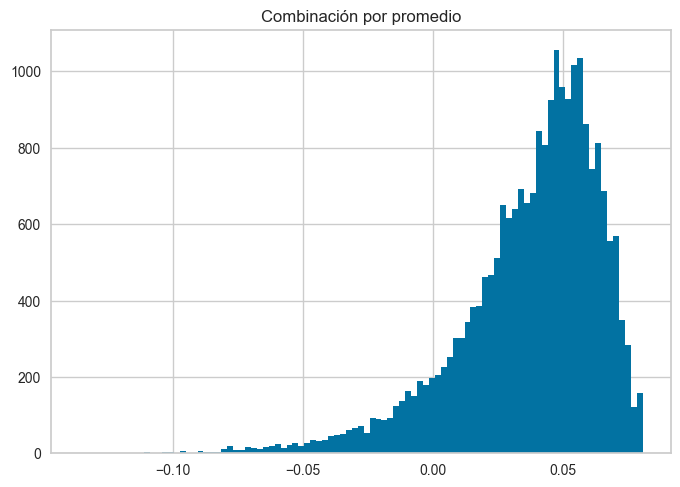

In [9]:
# El promedio de las predicciones de los 10 puntajes están en y_by_average abajo. Se crea esto en un histograma
# El resultado "y_by_average" es una columna:
Y_by_average = np.mean(iscores_mult,axis=1)
plt.hist(Y_by_average, bins = 'auto')
#plt.xlim(4.2, 8)
plt.title("Combinación por promedio")
plt.show()

In [11]:
threshold = np.percentile(np.sort(Y_by_average), 10)
threshold

0.0004654399597106756

In [126]:
len(Y_by_average[Y_by_average < threshold])

2279

(22782, 40)

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]])

In [93]:
if_gs.decision_function(emicron_ohe)

array([0.04222586, 0.05276294, 0.01945564, ..., 0.05920763, 0.06069718,
       0.02256103])

In [12]:
def descriptive_stat_threshold(df, pred_score, threshold, opcion = 1):
    # Observemos cuántos 0 o 1 hay
    if opcion == 1:    
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Normal', 'Outlier')
        # Ahora mostraremos las estadísticas resumen
        cnt = df.groupby('Group')['Anomaly_Score'].count().reset_index().rename(columns = {'Anomaly_Score': 'Count'})
        # Conto del conteo
        cnt['Count %'] = (cnt['Count'] / cnt['Count'].sum()) * 100
        # Promedio
        stat = df.groupby('Group').mean().round(2).reset_index()
        # Poniendo el conteo y el promedio juntos
        stat = cnt.merge(stat, left_on = 'Group', right_on = 'Group')
        return(stat)
    else:
        df = pd.DataFrame(df)
        df['Anomaly_Score'] = pred_score
        df['Group'] = np.where(df['Anomaly_Score'] < threshold, 'Outlier', 'Normal')
        return(df)

In [13]:
iforest_res = descriptive_stat_threshold(emicron, Y_by_average, threshold, 2)

In [16]:
iforest_res.to_csv(os.path.join(data_path,"atpcs_iforest_fijo.csv"), index = False)